In [1]:
%reload_ext autoreload
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns


import math


import cPickle as pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import tensorflow as tf

import statsmodels.api as sm

In [3]:
from __future__ import division

p = 100

n = 50

s = 10

wstar = np.concatenate((np.ones((s,)) / math.sqrt(s), np.zeros((p - s,))))

err_scale = 1

Scov = np.eye(p)

for i in xrange(p):
    if i % 2 == 1:
        Scov[i, i] = 2

X = np.random.multivariate_normal(np.zeros((p,)), np.eye(p), n)

Y = X.dot(wstar) + np.random.normal(scale=err_scale, size=n)



In [4]:
from sklearn.linear_model import Lasso

In [5]:
from __future__ import division

lasso_lambda = 2.0 * err_scale * math.sqrt(math.log(p) / n)

In [6]:
skl = Lasso(alpha=lasso_lambda, fit_intercept=False)

skl.fit(X, Y)

print skl.coef_

[ 0.          0.          0.          0.09408318  0.          0.          0.
  0.          0.          0.         -0.          0.         -0.         -0.
 -0.         -0.09995636  0.          0.          0.          0.         -0.
 -0.          0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.          0.         -0.          0.
 -0.         -0.         -0.         -0.          0.          0.          0.
  0.          0.         -0.          0.         -0.          0.          0.
  0.         -0.          0.          0.          0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.          0.          0.         -0.          0.          0.
 -0.          0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.          0.          0.         -0.          0.          0.
  0.         -0.          0.          0.          0.          0.          0.

In [7]:
import tensorflow as tf


def lasso_proxiaml_gd(X_, Y_, lasso_lambda_, eta, w_init, n_iter):
    eta = float(eta)
    
    n, p = X_.shape
    
    
    X = tf.placeholder(tf.float64, [None, p])
    
    Y = tf.placeholder(tf.float64, [None, 1])
    
    w = tf.Variable(w_init.reshape((-1, 1)), dtype=tf.float64)
    
    g = .5 * tf.reduce_mean(tf.square(tf.matmul(X, w) - Y))
    
    opt = tf.train.GradientDescentOptimizer(learning_rate=-1.0)
    
    g_grads_and_vars = opt.compute_gradients(g, [w])
    
    g_grad = g_grads_and_vars[0][0]
    
    w_prev = g_grads_and_vars[0][1]
    
    w_before_prox = w_prev - eta * g_grad
    
    w_prox = tf.nn.relu(w_before_prox - eta * lasso_lambda) \
        - tf.nn.relu(-w_before_prox - eta * lasso_lambda)
    
    opt_op = opt.apply_gradients([(w_prox - w_prev, g_grads_and_vars[0][1])])
    
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for i_ in xrange(n_iter):
            
            sess.run([opt_op], feed_dict={X: X_, Y: Y_.reshape((-1, 1))})

        w_hat = w.eval(session=sess).ravel()
    
    return w_hat


In [8]:
eta = 0.2

w_init = np.zeros((p,))

n_iter = 5000

w_pgd = lasso_proxiaml_gd(X, Y, lasso_lambda, eta, w_init, n_iter)

print w_pgd

[ 0.          0.          0.          0.09408317  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.         -0.09995636  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.

<IPython.core.display.Javascript object>


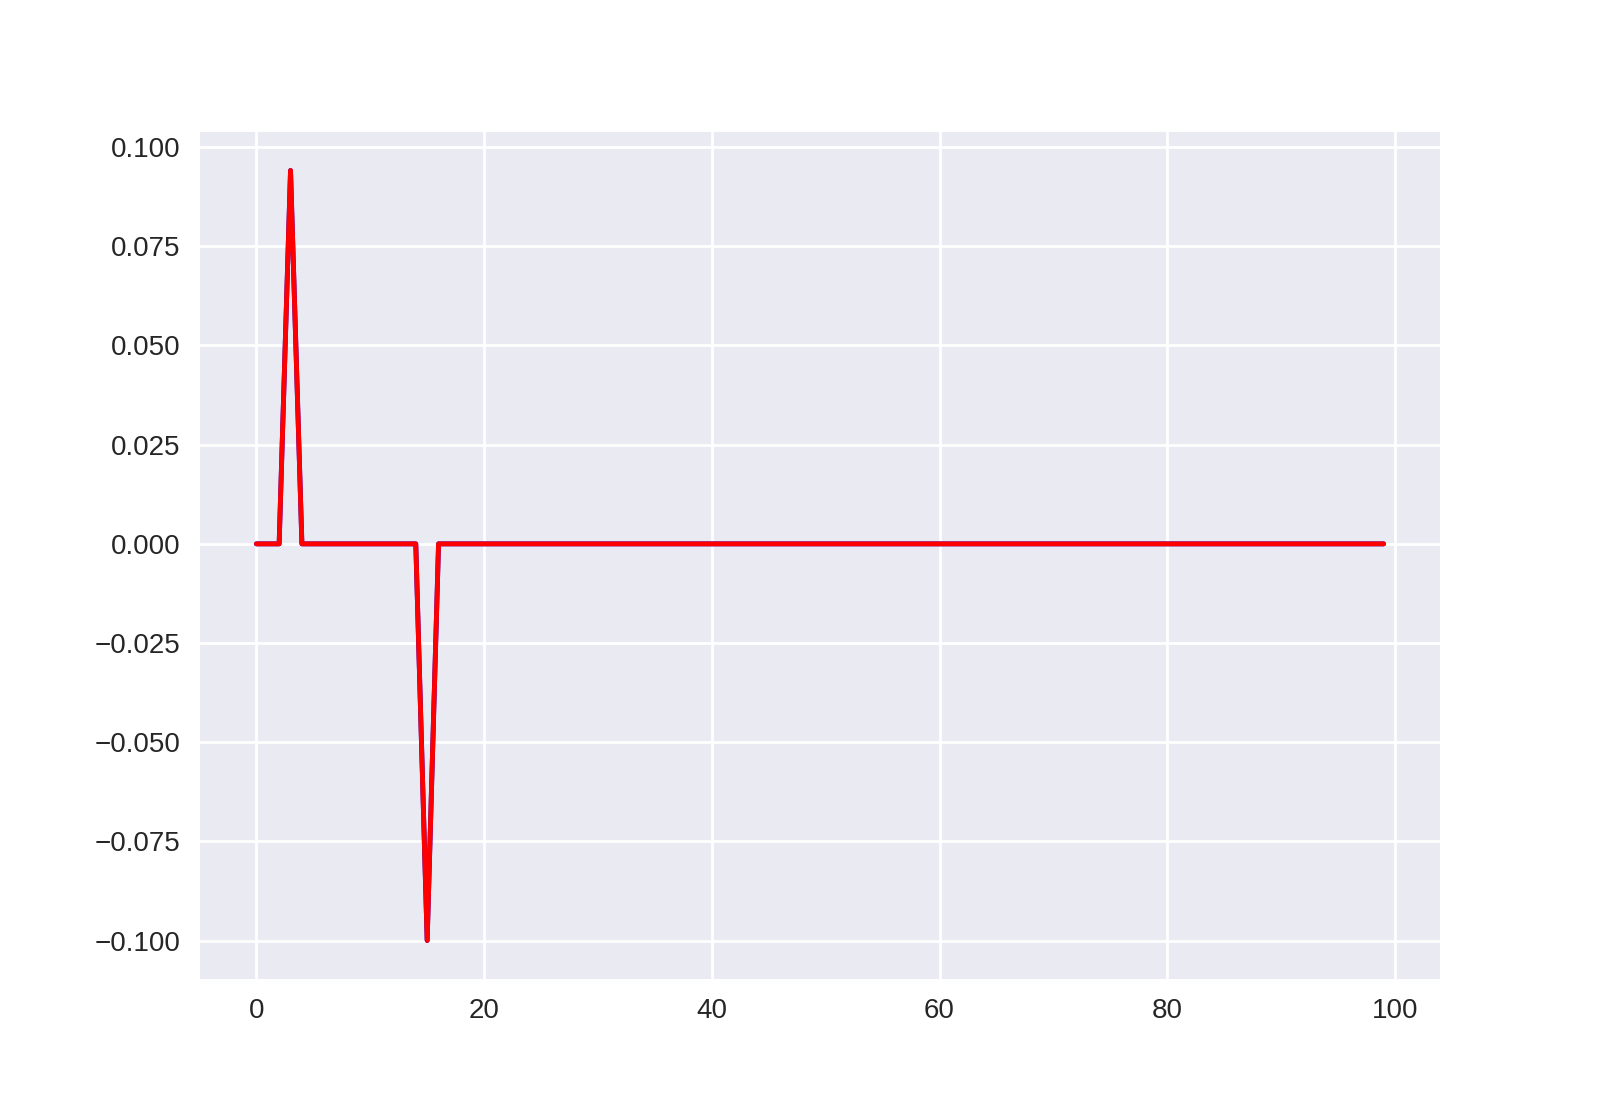

In [9]:
plt.figure()

plt.plot(skl.coef_, 'b', label="sklearn")

plt.plot(w_pgd, 'r', label="mine proximal GD")